<font size="6"><center>**Alpha Research: Feature Engineering**</font>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run ../nb_config.py

running notebook configuration


In [3]:
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error, accuracy_score

In [4]:
from src.data_api import sources
from src import utils, tags

from src import data_preparation as dataprep 

In [5]:
conf = utils.get_conf()

In [6]:
fparams = conf['func_params']

start_dt = fparams['start_dt']
end_dt = fparams['end_dt']
avol_top = float(fparams['avol_top'])
avol_window = int(fparams['avol_window'])
tau = int(fparams['target']['tau'])

In [7]:
ticker = 'AMZN'

# Load Data

In [8]:
wiki_prices = sources.read_wiki_prices()

In [9]:
pd.concat([wiki_prices.head(2), wiki_prices.tail(2)], axis=0)

,,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume
date,ticker,,,,,,,,,,,,
1999-11-18,A,45.5000,50.0000,40.0000,44.0000,"44,739,900.0000",0.0000,1.0000,31.0420,34.1120,27.2896,30.0186,"44,739,900.0000"
1999-11-19,A,42.9400,43.0000,39.8100,40.3800,"10,897,100.0000",0.0000,1.0000,29.2954,29.3363,27.1600,27.5489,"10,897,100.0000"
2018-03-26,ZUMZ,23.7500,24.8000,23.7000,24.6500,"375,320.0000",0.0000,1.0000,23.7500,24.8000,23.7000,24.6500,"375,320.0000"
2018-03-27,ZUMZ,24.6500,24.6500,23.3500,23.6000,"403,884.0000",0.0000,1.0000,24.6500,24.6500,23.3500,23.6000,"403,884.0000"


In [10]:
wiki_prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 15389314 entries, (Timestamp('1999-11-18 00:00:00'), 'A') to (Timestamp('2018-03-27 00:00:00'), 'ZUMZ')
Columns: 12 entries, open to adj_volume
dtypes: float64(12)
memory usage: 1.4+ GB


In [11]:
wiki_prices_meta = (sources.read_data(filename='us_equities_meta_data.csv', layer='raw')
                   .set_index(tags.TICKER)
                   )

wiki_prices_meta.head()

,name,lastsale,marketcap,ipoyear,sector,industry
ticker,,,,,,
PIH,"1347 Property Insurance Holdings, Inc.",7.2001,"43,090,000.0000","2,014.0000",Finance,Property-Casualty Insurers
PIHPP,"1347 Property Insurance Holdings, Inc.",25.6200,NaN,NaN,Finance,Property-Casualty Insurers
TURN,180 Degree Capital Corp.,2.2600,"70,330,000.0000",NaN,Finance,Finance/Investors Services
FLWS,"1-800 FLOWERS.COM, Inc.",12.9000,"833,390,000.0000","1,999.0000",Consumer Services,Other Specialty Stores
FCCY,1st Constitution Bancorp (NJ),21.3000,"178,140,000.0000",NaN,Finance,Savings Institutions


# Data Preparation

```python
def ohlc(open_col='adj_open', close_col='adj_close', high_col='adj_high', low_col='adj_low', rtol=0.01):
    """
    Create an alpha factor that takes high value when intraday prices has gone up and low value when intraday prices has gone down, for example:
    close > open -> +1
    close < open -> -1
    Explore some combinations
    """
def momentum(data: pd.DataFrame, close_col: str,  ticker_col='ticker', tau: int):
    """
    For each ticker, compute raw-returns (backwards) given a window length `tau`. This can be interpreted as a momemtum measure (1s derivate of price time series)
    This feature can be trend-follower (corr >0) or mean reverting (corr<0)
    """
```

In [12]:
min_yr = '2013'  # must be below start_dt (consdering feature windows)
select_cols = ['adj_open','adj_high','adj_low', 'adj_close', 'adj_volume']

mask_min_yr = wiki_prices.index.get_level_values(tags.DATE)>=pd.Timestamp(min_yr)

feats_and_targets = (wiki_prices
    .loc[mask_min_yr, select_cols]
    .pipe(dataprep.pl_min_avol_filter, window=avol_window, top_n=avol_top)
    .pipe(dataprep.pl_add_sector, sector_map=wiki_prices_meta['sector'])
    .pipe(dataprep.pl_targets, tau_fwd=tau)
    .pipe(dataprep.pl_features)
    .pipe(dataprep.pl_date_filter, start_dt=start_dt, end_dt=end_dt)
    .filter(regex=('x_|y_|sector'))
                    )


In [13]:
pd.concat([feats_and_targets.head(2), feats_and_targets.tail(2)], axis=0)

,,sector,y_fwd_logrets_5d,x_returns_5d,x_returns_1y,x_ohlc_intraday
date,ticker,,,,,
2015-01-02,A,Capital Goods,0.0007,-0.0115,0.1108,-3
2015-01-05,A,Capital Goods,0.0078,-0.0365,0.0742,-3
2017-12-28,ZTS,Health Care,0.0133,-0.0044,0.3577,-3
2017-12-29,ZTS,Health Care,0.0301,-0.0033,0.3534,-3


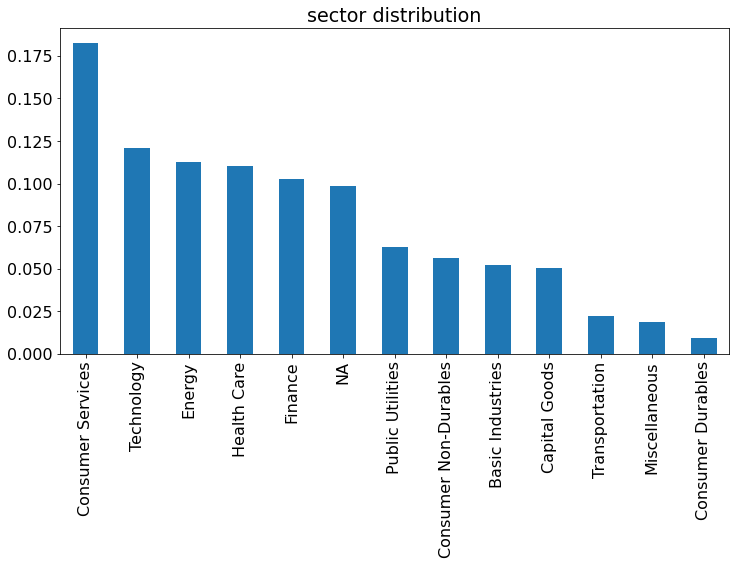

In [14]:
feats_and_targets['sector'].value_counts(normalize=True).plot.bar()
plt.title('sector distribution')
plt.show()

## Feature Engineering

## Demean

Substract mean factor value by sector to remove general sector effect from each single ticker (sector neutralization)

```python
def factor_demean(data: pd.DataFrame, factor_col: str, sector_col='sector', date_col='date', return_frame=False):
    """
    On each period, substract mean factor value by sector to remove general sector effect from each single ticker (sector neutralization)
    """
```

In [ ]:
feats_and_targets['x_returns_1y_demean'] = dataprep.factor_demean(feats_and_targets, 'x_returns_1y')

## Rank

Compute a daily ranking of stocks to deal with outliers and reduce noise

```python 
def factor_rank(data: pd.DataFrame, factor_col: str, date_col='date', return_frame=False):
    """
    On each period, rank to factor values, assigning 1 to the lowest factor value and N to the largest
    """
```

In [ ]:
feats_and_targets['x_returns_1y_dm_rnk'] = dataprep.factor_rank(feats_and_targets, factor_col='x_returns_1y_demean')

## Z-score

Substract daily mean and divide by daily std-dev

```python
def zscore(x: pd.Series):
    return (x - np.mean(x))/np.std(x)
    
def factor_zscore(data: pd.DataFrame, factor_col: str, date_col='date', return_frame=False):
    """
    On each period, compute factor mean and std and standardize factor values
    """
```

In [ ]:
feats_and_targets['x_returns_1y_dm_zsco'] = dataprep.factor_zscore(feats_and_targets, factor_col='x_returns_1y_demean')

## Smooth

Reduce noise and outliers by computing rolling average over time (for each ticker)

```python
def smooth(x, window: int):
    return x.rolling(window).mean()

def factor_smooth(data: pd.DataFrame, factor_col: str, ticker_col='ticker', window=20, return_frame=False):
    """
    Compute rolling average for each ticker factor values
    """
```


In [18]:
feats_and_targets['x_returns_1y_dm_smooth'] = dataprep.factor_smooth(feats_and_targets, factor_col='x_returns_1y_demean',  window=5)

In [19]:
#feats_and_targets['x_returns_1y_fte'] = (
#    feats_and_targets
#        .pipe(factor_demean, factor_col='x_returns_1y',  date_col='date', return_frame=True)
#        .pipe(factor_zscore, factor_col='x_returns_1y', date_col='date', return_frame=True)
#        .pipe(factor_smooth, factor_col='x_returns_1y', ticker_col='ticker', window=3, return_frame=True)
#        ) 

# Visualization

In [20]:
SMPL_DATE = '2017-12-29'

In [21]:
cols_features = ['x_returns_1y', 'x_returns_1y_demean', 'x_returns_1y_dm_rnk', 'x_returns_1y_dm_zsco', 'x_returns_1y_dm_smooth']
cols_all = cols_features + [tags.TARGET]

In [22]:
smpl_day_1y_rets = feats_and_targets.xs(level=tags.DATE, key=SMPL_DATE)[cols_features].dropna().sort_values(by='x_returns_1y')

In [23]:
pd.concat([smpl_day_1y_rets.head(), smpl_day_1y_rets.tail()])

,x_returns_1y,x_returns_1y_demean,x_returns_1y_dm_rnk,x_returns_1y_dm_zsco,x_returns_1y_dm_smooth
ticker,,,,,
MNKD,-0.9530,-1.1512,1.0000,-2.1803,-1.1212
SDRL,-0.9322,-0.9479,3.0000,-1.7954,-0.9262
RAD,-0.7609,-0.9591,2.0000,-1.8166,-0.9276
TNK,-0.7172,-0.8292,6.0000,-1.5705,-0.8287
ACHN,-0.6959,-0.8941,4.0000,-1.6934,-0.8482
VMW,1.8061,1.3970,423.0000,2.6460,1.4354
FOLD,1.9427,1.7446,425.0000,3.3043,1.8224
UPL,3.4631,3.4473,427.0000,6.5293,2.9745
TTWO,3.6995,3.2904,426.0000,6.2322,3.2726


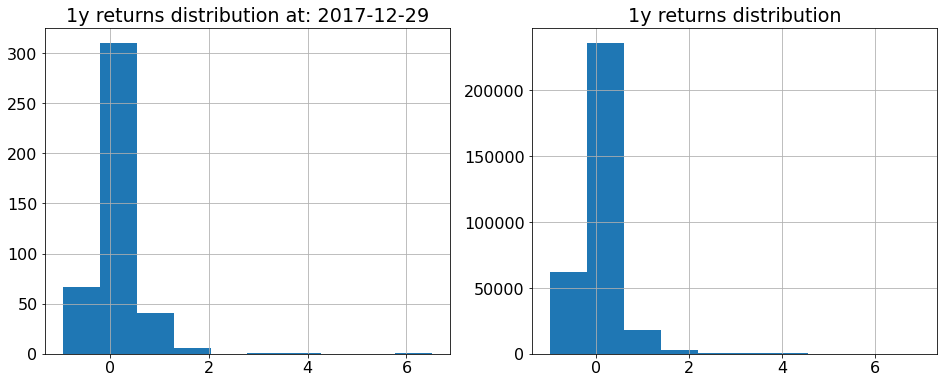

In [24]:
fig, axs = plt.subplots(1,2, figsize=(16,6))

ax = axs[0]
smpl_day_1y_rets['x_returns_1y'].hist(ax=ax)
ax.set_title(f'1y returns distribution at: {SMPL_DATE}')

ax = axs[1]
feats_and_targets['x_returns_1y'].hist(ax=ax)
ax.set_title(f'1y returns distribution')
plt.show()

In [25]:
smpl_day_1y_rets.describe()

,x_returns_1y,x_returns_1y_demean,x_returns_1y_dm_rnk,x_returns_1y_dm_zsco,x_returns_1y_dm_smooth
count,427.0000,427.0000,427.0000,427.0000,427.0000
mean,0.1760,-0.0005,214.2131,-0.0009,0.0016
std,0.5457,0.5291,123.6997,1.0022,0.5094
min,-0.9530,-1.1512,1.0000,-2.1803,-1.1212
25%,-0.0861,-0.2423,107.5000,-0.4590,-0.2292
50%,0.1416,-0.0272,214.0000,-0.0515,-0.0252
75%,0.3503,0.1555,320.5000,0.2945,0.1517
max,6.5163,6.3181,428.0000,11.9667,5.9227


In [26]:
feats_and_targets.describe()

,y_fwd_logrets_5d,x_returns_5d,x_returns_1y,x_ohlc_intraday,x_returns_1y_demean,x_returns_1y_dm_rnk,x_returns_1y_dm_zsco,x_returns_1y_dm_smooth
count,"374,331.0000","372,809.0000","321,105.0000","374,331.0000","321,105.0000","321,105.0000","321,105.0000","318,554.0000"
mean,-0.0002,-0.0003,0.0929,0.0838,0.0000,213.6058,-0.0000,-0.0005
std,0.0797,0.0854,0.4426,2.5265,0.3929,123.2415,1.0000,0.3887
min,-3.3884,-3.3884,-0.9917,-3.0000,-1.5835,1.0000,-3.7134,-1.5567
25%,-0.0215,-0.0219,-0.1335,-3.0000,-0.1870,107.0000,-0.4924,-0.1859
50%,0.0021,0.0019,0.0712,0.0000,-0.0081,213.0000,-0.0218,-0.0080
75%,0.0245,0.0245,0.2630,3.0000,0.1467,320.0000,0.3937,0.1454
max,3.6065,3.6065,6.9432,3.0000,6.7292,450.0000,14.0570,6.3141


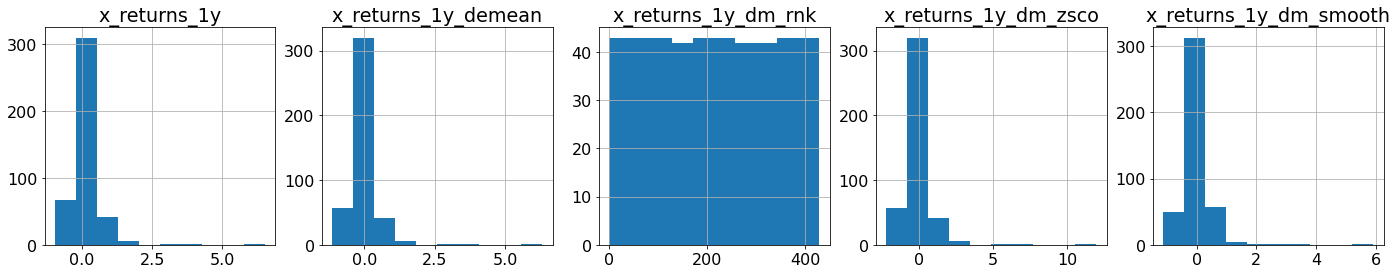

In [27]:
fig, axs = plt.subplots(1, len(cols_features), figsize=(24,4))


for i_col, col_name in enumerate(cols_features):

    ax = axs[i_col]
    smpl_day_1y_rets[col_name].hist(ax=ax)
    ax.set_title(col_name)
    
plt.show()

# Correlation Analysis

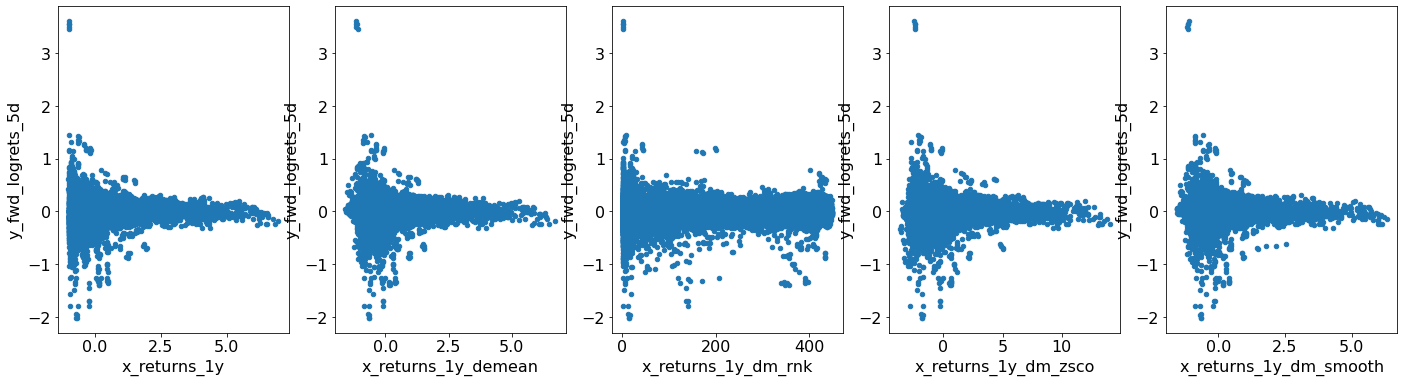

In [28]:
fig, axs = plt.subplots(1, len(cols_features), figsize=(24,6))

for i_col, col_name in enumerate(cols_features):

    ax = axs[i_col]
    feats_and_targets.plot.scatter(x=col_name, y=tags.TARGET, ax=ax)
    ax.set_xlabel(col_name)
    
plt.show()

In [29]:
corr = feats_and_targets[cols_all].corr(method='spearman')

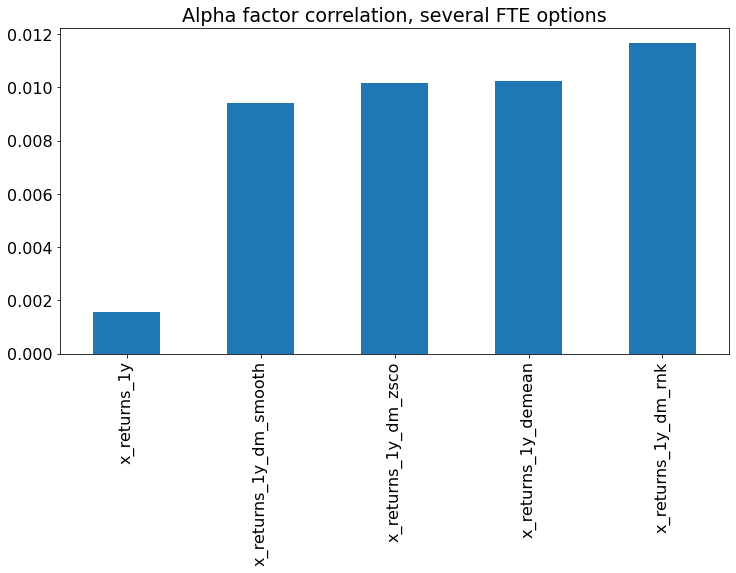

In [30]:
corr.loc[cols_features, tags.TARGET].sort_values().plot.bar()
plt.title('Alpha factor correlation, several FTE options')
plt.show()

In [31]:
alpha_factor_name = 'x_returns_1y_dm_zsco'

In [32]:
corr_over_time = (feats_and_targets
                  .groupby(tags.DATE)[[alpha_factor_name, tags.TARGET]]
                  .corr(method='spearman')
                  .xs(level=1, key=alpha_factor_name)[tags.TARGET]
                 )

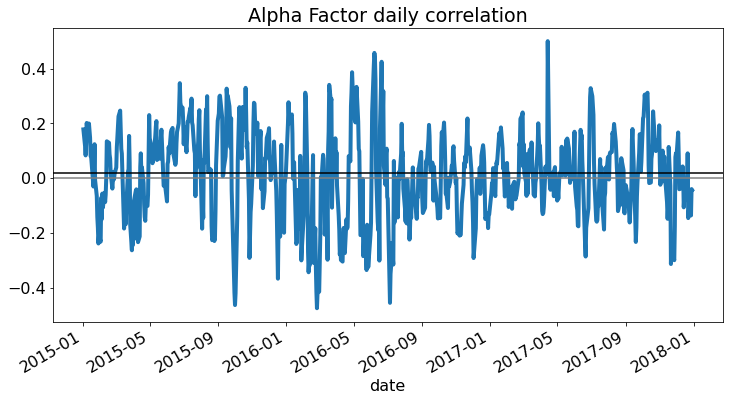

In [33]:
corr_over_time.plot()
plt.axhline(corr_over_time.median(), linewidth=1.5, color='black')
plt.axhline(0, linewidth=1.5, color='grey')
plt.title('Alpha Factor daily correlation')
plt.show()

In [34]:
corr_over_ticker = (feats_and_targets
                    .groupby(tags.TICKER)[[alpha_factor_name, tags.TARGET]]
                    .corr(method='spearman')
                    .xs(level=1, key=alpha_factor_name)[tags.TARGET]
                    .dropna()
                    .sort_values()
                   )

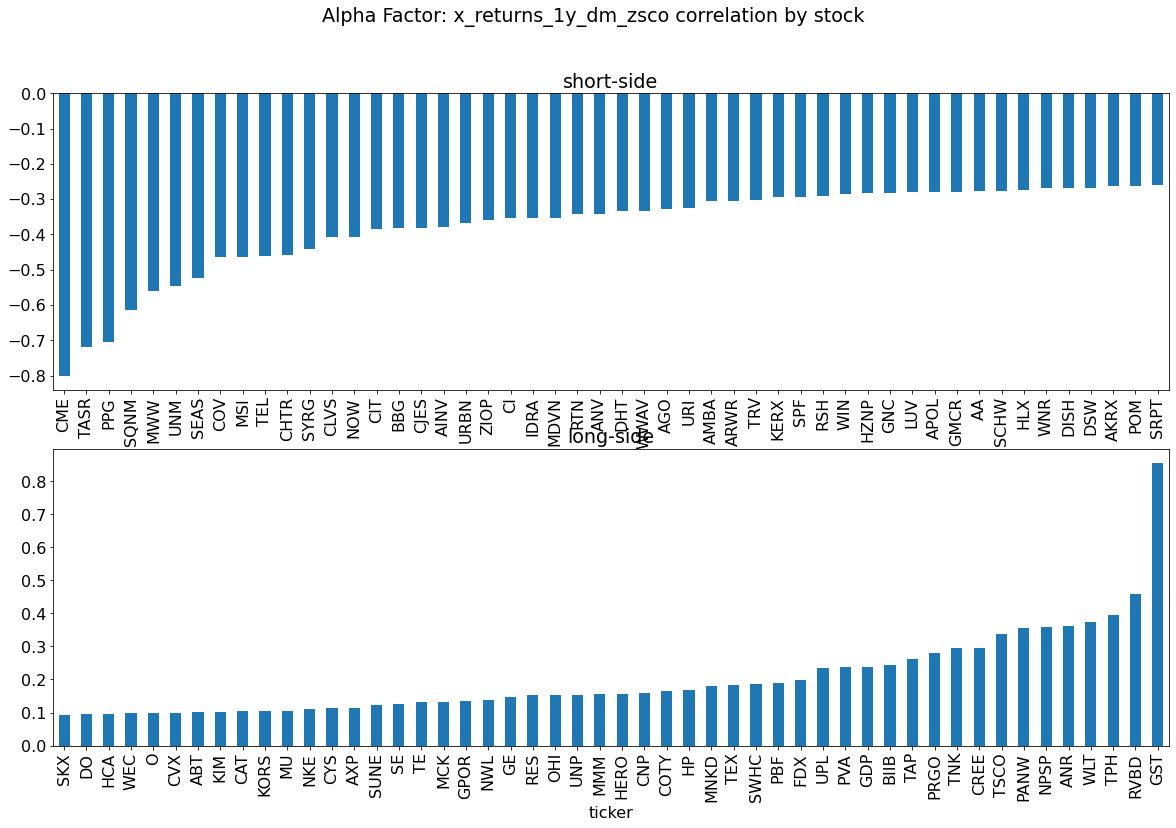

In [35]:
fig, axs = plt.subplots(2,1, figsize=(20, 12))

ax = axs[0]
corr_over_ticker.iloc[:50].plot.bar(ax=ax)
ax.set_title('short-side')

ax = axs[1]
corr_over_ticker.iloc[-50:].plot.bar(ax=ax)
ax.set_title('long-side')

plt.suptitle(f'Alpha Factor: {alpha_factor_name} correlation by stock')
plt.show()

# Benchmark model

In [36]:
X_y_benchmark = feats_and_targets[[alpha_factor_name, tags.TARGET]].dropna()

In [37]:
X_y_benchmark.corr(method='spearman')

,x_returns_1y_dm_zsco,y_fwd_logrets_5d
x_returns_1y_dm_zsco,1.0000,0.0102
y_fwd_logrets_5d,0.0102,1.0000


In [38]:
mean_squared_error(y_true=X_y_benchmark[alpha_factor_name], y_pred=X_y_benchmark[tags.TARGET])

1.0028130159334918

In [39]:
accuracy_score(y_true=np.sign(X_y_benchmark[alpha_factor_name]), y_pred=np.sign(X_y_benchmark[tags.TARGET]))

0.5037012815122779